In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
Min_Max = preprocessing.MinMaxScaler()
Ordinal =preprocessing.OrdinalEncoder()


def one_hot_cols(df,cols_to_one):
    one_hot=pd.get_dummies(df,cols_to_one,columns=cols_to_one)
    return one_hot


def fit_cols(df, cols_to_fit,fit_function ):
    for col in cols_to_fit:
        df[col] = pd.DataFrame(fit_function.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df


def split_Dataset(mypandas, cols_for_Y,size=0.2,state=1):
    
    X =  mypandas.drop(cols_for_Y, axis=1)
    Y = mypandas[cols_for_Y]
    X.head()

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, random_state=state)
    X_train, X_testVal, Y_train, Y_testVal = train_test_split(X_train, Y_train, test_size=0.1, random_state=state)
    return X_train.to_numpy(), X_test.to_numpy(), Y_train.to_numpy(), Y_test.to_numpy(), X_testVal.to_numpy(), Y_testVal.to_numpy()

In [5]:
data = pd.read_csv('datasets/smoke_detection_iot.csv', encoding='utf-8' )
display(data)
dataset= fit_cols(data,data.columns,Min_Max)



,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


In [7]:
X_train,X_test , Y_train, Y_test, X_trainVal, Y_trainVal = split_Dataset(data,['Fire Alarm'])

In [9]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}, X_trainval:{}, trainVal:{}".format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, X_trainVal.shape, Y_trainVal.shape  ))

X Train: (45093, 15), X Test: (12526, 15), y_train: (45093, 1), y_test: (12526, 1), X_trainval:(5011, 15), trainVal:(5011, 1)


In [16]:
n_entradas = X_train.shape[1]
Y_train

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]])

In [10]:
t_X_train = torch.from_numpy(X_train).float().to("cpu") #MPS #cuda
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(Y_train).float().to("cpu")
t_y_test = torch.from_numpy(Y_test).float().to("cpu")
t_X_trainval= torch.from_numpy(X_trainVal).float().to("cpu")
t_Y_trainval= torch.from_numpy(Y_trainVal).float().to("cpu")
#t_y_train = t_y_train[:,None]
#t_y_test = t_y_test[:, None]

In [12]:
test = TensorDataset(t_X_test, t_y_test)
val = TensorDataset(t_X_trainval, t_Y_trainval)
print(test[0])
print(val[0])

(tensor([3.6794e-01, 1.0575e-01, 7.2004e-04, 6.3559e-01, 2.2150e-02, 0.0000e+00,
        7.3652e-01, 6.7093e-01, 8.7168e-01, 1.2907e-04, 4.2481e-05, 2.0754e-04,
        3.8332e-05, 1.4987e-06, 9.2202e-01]), tensor([1.]))
(tensor([2.0345e-01, 8.1093e-02, 5.2092e-01, 5.6593e-01, 1.7333e-02, 2.2987e-03,
        6.9282e-01, 6.8193e-01, 9.0010e-01, 1.4442e-04, 4.7323e-05, 2.3112e-04,
        4.2685e-05, 1.6652e-06, 5.0982e-01]), tensor([1.]))


In [13]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)
        self.linear2 = nn.Linear(15, 8)
        self.linear3 = nn.Linear(8, 1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))
        return pred_f

In [14]:
t_X_train.shape
t_y_train.shape

torch.Size([50104, 1])

In [30]:
%%time
lr = 0.002
epochs = 8000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entranando el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=15, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=1, bias=True)
)
Entranando el modelo

Epoch 100 	 Loss: 0.5913
Accuracy: 70.89253997802734

Epoch 200 	 Loss: 0.5749
Accuracy: 70.89253997802734

Epoch 300 	 Loss: 0.5252
Accuracy: 70.95641326904297

Epoch 400 	 Loss: 0.4155
Accuracy: 80.61631774902344

Epoch 500 	 Loss: 0.3039
Accuracy: 87.59380340576172

Epoch 600 	 Loss: 0.2235
Accuracy: 93.39773559570312

Epoch 700 	 Loss: 0.1791
Accuracy: 96.08015441894531

Epoch 800 	 Loss: 0.1549
Accuracy: 96.5910873413086

Epoch 900 	 Loss: 0.1398
Accuracy: 96.886474609375

Epoch 1000 	 Loss: 0.1293
Accuracy: 97.1818618774414

Epoch 1100 	 Loss: 0.1214
Accuracy: 97.4453125

Epoch 1200 	 Loss: 0.1152
Accuracy: 97.684814453125

Epoch 1300 	 Loss: 0.1101
Accuracy: 97.8205337524414

Epoch 1400 	 Loss: 0.1058
Accuracy: 97.9802017211914

Epoch 1500 

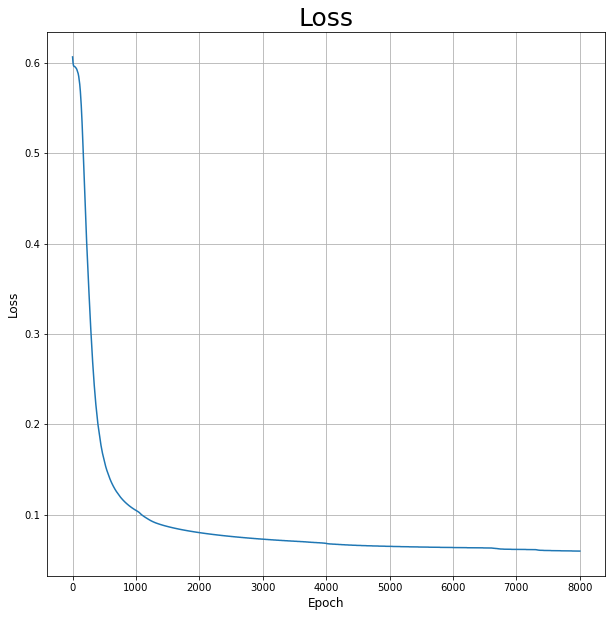

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

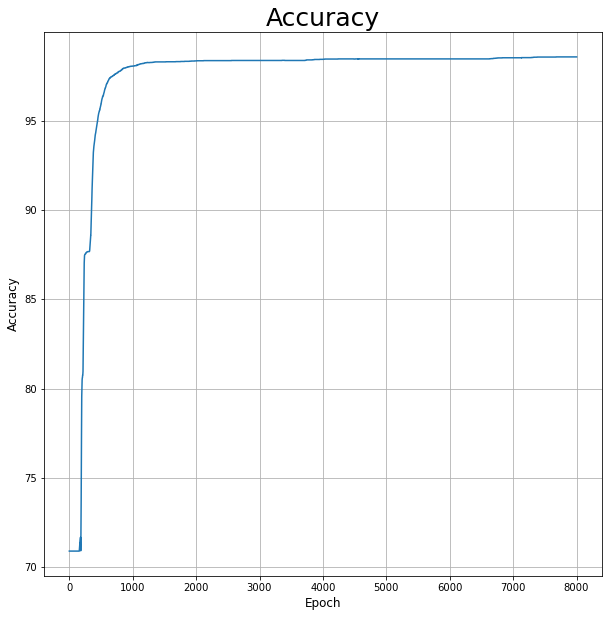

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

In [20]:
t_X_test[1500]

tensor([4.7989e-01, 1.2975e-01, 5.4003e-01, 5.8796e-01, 7.5000e-04, 0.0000e+00,
        8.1946e-01, 7.9616e-01, 9.7869e-01, 1.3814e-04, 4.5122e-05, 2.2120e-04,
        4.0855e-05, 1.5986e-06, 2.0250e-01])

In [27]:
prediccion = model(t_X_test[9500])
print(prediccion)

tensor([1.], grad_fn=<SigmoidBackward0>)


In [28]:
t_y_test[1500]

tensor([1.])